## Comparing [SPCI](https://arxiv.org/abs/2212.03463) with EnbPI

EnbPI
* Conference version: [ICML 2021](https://proceedings.mlr.press/v139/xu21h.html)
* Extended journal version: [IEEE TPAMI](https://ieeexplore.ieee.org/abstract/document/10121511)

In [ ]:
# Install packages if not yet available
! pip install skranger 

! pip install statsmodels

! pip install sklearn_quantile

! pip install scikit-learn==1.1.2

### To use [EnbPI](https://arxiv.org/abs/2010.09107), which is fast

In general, just pass in `X_full, Y_full` which are torch.tensor and specify what are the training samples and test samples by changing `train_frac`. Also, adjust `past_window` to specify the amount of past residuals to use when constructing intervals. 

For EnbPI, larger `past_window` will make intervals wider.

In [1]:
# Define or get data
import data 
import torch
dloader = data.real_data_loader()
X_full, Y_full = dloader.electric_dataset()
X_full = torch.from_numpy(X_full)
Y_full = torch.from_numpy(Y_full)
print('Full data shape')
print(X_full.shape, Y_full.shape)
# Use 80% for training
train_frac = 0.8
N = int(X_full.shape[0] * train_frac)
X_train, X_predict, Y_train, Y_predict = X_full[:N], X_full[N:], Y_full[:N], Y_full[N:]
# Use past_window # past residuals to predict the next one. If there are not so many residuals, one can decrease it
past_window = 300 
print(f'We will thus construct {len(Y_predict)} prediction intervals during test time')

Full data shape
torch.Size([3444, 4]) torch.Size([3444])
We will thus construct 689 prediction intervals during test time


In [2]:
# Initialize the SPCI class
from sklearn.ensemble import RandomForestRegressor
import SPCI_class as SPCI
fit_func = RandomForestRegressor(n_estimators=10, max_depth=1, criterion='mse',
                                bootstrap=False, n_jobs=-1, random_state=1103)
EnbPI_class_  = SPCI.SPCI_and_EnbPI(X_train, X_predict, Y_train, Y_predict, fit_func=fit_func)
stride = 1
EnbPI_class_.fit_bootstrap_models_online_multistep(
            B = 25, fit_sigmaX=False, stride=stride)
alpha = 0.1 # 90% prediction interval

1/1 multi-step: finish Fitting 25 Bootstrap models, took 0.7486340999603271 secs.


In [3]:
use_SPCI = False
smallT = not use_SPCI
EnbPI_class_.compute_PIs_Ensemble_online(
    alpha, smallT=smallT, past_window=past_window, use_SPCI=use_SPCI,
    quantile_regr=False, stride=stride)
results = EnbPI_class_.get_results(alpha, 'my_data', 1)

Shape of slided residual lists is (689, 300)
Finish Computing 689 UNIQUE Prediction Intervals, took 1.333888053894043 secs.
Average Coverage is 0.9085631349782293
Average Width is 0.3219615583887444


Text(0.5, 1.0, 'Target coverage is 90.00%. \n Actual coverage is 90.86% \n Average interval width is 0.32')

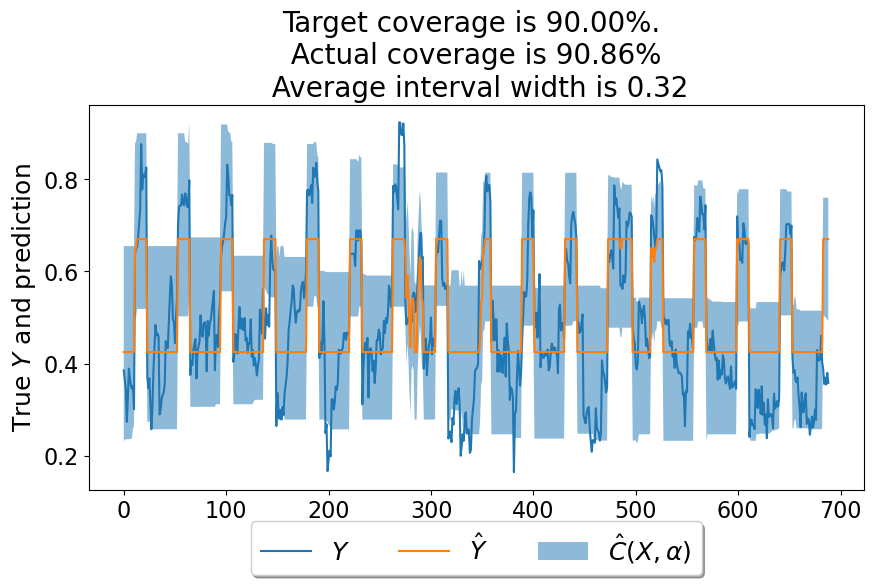

In [4]:
# Plot prediction intervals on test sample
Pred_ints = EnbPI_class_.PIs_Ensemble
Y_est = EnbPI_class_.Ensemble_pred_interval_centers
Y_predict = EnbPI_class_.Y_predict.numpy()
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10, 5))
plt.plot(Y_predict, label=r'$Y$')
plt.plot(Y_est, label=r'$\hat{Y}$')
plt.fill_between(np.arange(len(Y_predict)), Pred_ints['lower'], Pred_ints['upper'], alpha=0.5, label=r'$\hat{C}(X,\alpha)$')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
           fancybox=True, shadow=True, ncol=3)
plt.xlabel('Test time index')
plt.ylabel('True $Y$ and prediction')
actual_cov = 100*results["coverage"].item()
actual_wid = results["width"].item()
plt.title(f'Target coverage is {100*(1-alpha):.2f}%. \n Actual coverage is {actual_cov:.2f}% \n Average interval width is {actual_wid:.2f}')

### To use [SPCI](https://arxiv.org/abs/2212.03463), which performs better (i.e., intervals are narrower) but slower

In general, just pass in `X_full, Y_full` which are torch.tensor and specify what are the training samples and test samples by changing `train_frac`. Also, adjust `past_window` to specify the amount of past residuals to use when constructing intervals. 

For SPCI, larger `past_window` may or may not be better, depending on if there are "shifts" in the data distribution.

In [5]:
# Define or get data
import data 
import torch
dloader = data.real_data_loader()
X_full, Y_full = dloader.electric_dataset()
X_full = torch.from_numpy(X_full)
Y_full = torch.from_numpy(Y_full)
print('Full data shape')
print(X_full.shape, Y_full.shape)
# Use 80% for training
train_frac = 0.8
N = int(X_full.shape[0] * train_frac)
X_train, X_predict, Y_train, Y_predict = X_full[:N], X_full[N:], Y_full[:N], Y_full[N:]
# Use past_window # past residuals to predict the next one. If there are not so many residuals, one can decrease it
past_window = 300 
print(f'We will thus construct {len(Y_predict)} prediction intervals during test time')

Full data shape
torch.Size([3444, 4]) torch.Size([3444])
We will thus construct 689 prediction intervals during test time


In [6]:
# Initialize the SPCI class
from sklearn.ensemble import RandomForestRegressor
import SPCI_class as SPCI
fit_func = RandomForestRegressor(n_estimators=10, max_depth=1, criterion='mse',
                                bootstrap=False, n_jobs=-1, random_state=1103)
SPCI_class_  = SPCI.SPCI_and_EnbPI(X_train, X_predict, Y_train, Y_predict, fit_func=fit_func)
stride = 1
SPCI_class_.fit_bootstrap_models_online_multistep(
            B = 25, fit_sigmaX=False, stride=stride)
alpha = 0.1 # 90% prediction interval

1/1 multi-step: finish Fitting 25 Bootstrap models, took 0.7078924179077148 secs.


In [7]:
use_SPCI = True
smallT = not use_SPCI
SPCI_class_.compute_PIs_Ensemble_online(
    alpha, smallT=smallT, past_window=past_window, use_SPCI=use_SPCI,
    quantile_regr=True, stride=stride)
results = SPCI_class_.get_results(alpha, 'my_data', 1)

Shape of slided residual lists is (689, 2755)
Width at test 0 is 0.18689065799117088
Width at test 34 is 0.26262082904577255
Width at test 68 is 0.1886167787015438
Width at test 102 is 0.3147000689059496
Width at test 136 is 0.2604992464184761
Width at test 170 is 0.20281972736120224
Width at test 204 is 0.27776073291897774
Width at test 238 is 0.21463420242071152
Width at test 272 is 0.2511063814163208
Width at test 306 is 0.19279605895280838
Width at test 340 is 0.2691938951611519
Width at test 374 is 0.19584429636597633
Width at test 408 is 0.19678916782140732
Width at test 442 is 0.20713061839342117
Width at test 476 is 0.19654162228107452
Width at test 510 is 0.20749354362487793
Width at test 544 is 0.19167885929346085
Width at test 578 is 0.19495859742164612
Width at test 612 is 0.2643210254609585
Width at test 646 is 0.22696785628795624
Width at test 680 is 0.18333569169044495
Finish Computing 689 UNIQUE Prediction Intervals, took 133.43916201591492 secs.
Average Coverage is 0.9

Text(0.5, 1.0, 'Target coverage is 90.00%. \n Actual coverage is 93.03% \n Average interval width is 0.22')

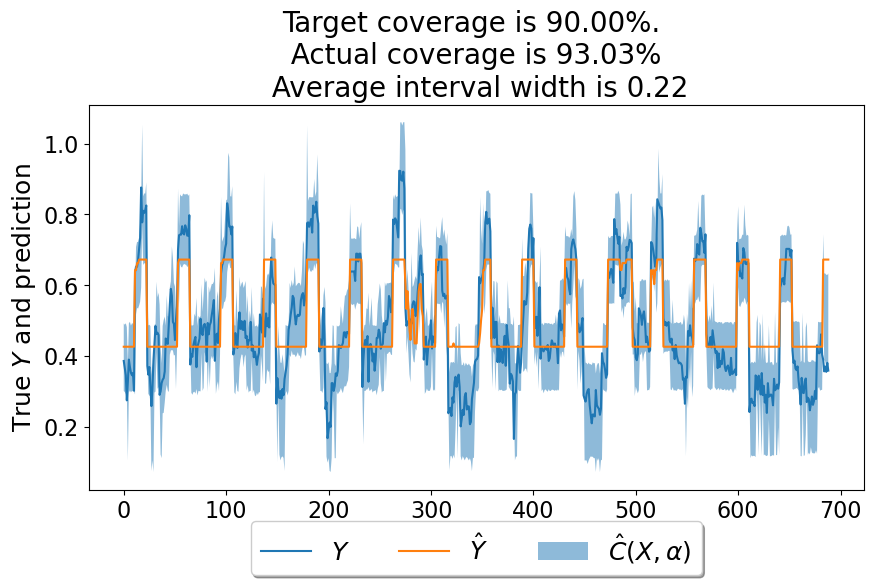

In [11]:
# Plot prediction intervals on test sample
Pred_ints = SPCI_class_.PIs_Ensemble
Y_est = SPCI_class_.Ensemble_pred_interval_centers
Y_predict = SPCI_class_.Y_predict.numpy()
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10, 5))
plt.plot(Y_predict, label=r'$Y$')
plt.plot(Y_est, label=r'$\hat{Y}$')
plt.fill_between(np.arange(len(Y_predict)), Pred_ints['lower'], Pred_ints['upper'], alpha=0.5, label=r'$\hat{C}(X,\alpha)$')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
           fancybox=True, shadow=True, ncol=3)
plt.xlabel('Test time index')
plt.ylabel('True $Y$ and prediction')
actual_cov = 100*results["coverage"].item()
actual_wid = results["width"].item()
plt.title(f'Target coverage is {100*(1-alpha):.2f}%. \n Actual coverage is {actual_cov:.2f}% \n Average interval width is {actual_wid:.2f}')